In [1]:
import pandas as pd
import scipy
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from utils.generators import UserGenerator

In [2]:
%matplotlib inline

In [3]:
# A simple generator to simulate userdata
ug = UserGenerator(column_label='Clickthrough Rate')

In [4]:
# creating a dataframe prelabeled for AB testing
# the outcome will contain 2 groups, A with a success rate of 12% B with a success rate of 10 % . 
df = ug.generate_ab_split_df(nr_of_users=4000,positive_ratio_A=0.12, positive_ratio_B=0.1, nr_of_days=5,AB_user_ratio=0.5)

In [5]:
# looking at the data
df.head(2)

,user_id,Clickthrough Rate,datetime,group
0,uid_3351,1,2020-01-02 18:38:49,A
1,uid_3352,0,2020-01-04 17:22:52,A


In [6]:
# creating a label to make a more visual plot
df['hour'] =  df.datetime.dt.day.astype(str) + df.datetime.dt.hour.astype(str)

[Text(0, 0.5, 'Häufigkeit'), Text(0.5, 0, 'Clickthrough Rate')]

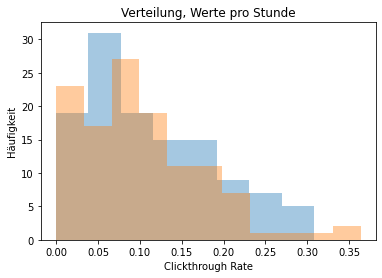

In [7]:
# Plot the hour grouped mean clickthrogh distribution
ax = sns.distplot(df.loc[df.group == 'A'].groupby(['hour'])['Clickthrough Rate'].mean(), kde=False)
ax = sns.distplot(df.loc[df.group == 'B'].groupby(['hour'])['Clickthrough Rate'].mean(), kde=False)
ax.set_title('Verteilung, Werte pro Stunde')
ax.set(xlabel='Clickthrough Rate', ylabel='Häufigkeit')

In [8]:
# NOT THE RIGHT WAY !
# simplest approaches with wrong / questionable assumptions.
# let's assume normal distributed means. 
# all we need are the means and standard deviations 

# compare with Unpaired t- test.  Unpaired because the two datasets are not paired up.
df.groupby('group')['Clickthrough Rate'].mean()
df.groupby('group')['Clickthrough Rate'].std()

group
A    0.312344
B    0.298737
Name: Clickthrough Rate, dtype: float64

In [9]:
group_A_modelassumptions = np.random.normal(loc = df.loc[df.group == 'A']['Clickthrough Rate'].mean()
                 , scale=df.loc[df.group == 'A']['Clickthrough Rate'].std()
                 , size =100 )

group_B_modelassumptions = np.random.normal(loc = df.loc[df.group == 'B']['Clickthrough Rate'].mean()
                 , scale=df.loc[df.group == 'A']['Clickthrough Rate'].std()
                 , size =100 )

[Text(0, 0.5, 'Häufigkeit'), Text(0.5, 0, 'Clickthrough Rate')]

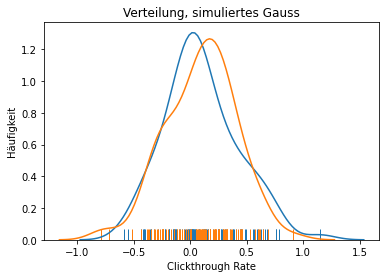

In [10]:
# Plot what the model assumes is happening :
ax = sns.distplot(group_A_modelassumptions, kde=True, hist=False, rug=True)
ax = sns.distplot(group_B_modelassumptions, kde=True, hist=False, rug= True)
ax.set_title('Verteilung, simuliertes Gauss')
ax.set(xlabel='Clickthrough Rate', ylabel='Häufigkeit')

In [11]:
t_statistic, p_value = scipy.stats.ttest_ind(df.loc[df.group=='A']['Clickthrough Rate'],df.loc[df.group=='B']['Clickthrough Rate'] )

In [12]:
# t statistic
t_statistic

1.0864590464234363

In [13]:
# p value
p_value #  this is above 0.05   so we assume there is no difference between A and B

0.27734144975482533

In [14]:
# proper assumptions Binomial Distribution
# Fischers Exact test 

In [15]:
# 2X2 contingency table
def create_contingency(df):
    """
    create a contingency table
    """
    contingency = {'A': {'0': df.loc[df.group=='A'].shape[0] - df.loc[df.group=='A']['Clickthrough Rate'].sum() 
                     
                     ,'1': df.loc[df.group=='A']['Clickthrough Rate'].sum() 
                    }
               
               ,'B': {'0': df.loc[df.group=='B'].shape[0] - df.loc[df.group=='B']['Clickthrough Rate'].sum() 
                     
                     ,'1': df.loc[df.group=='B']['Clickthrough Rate'].sum() 
                    }
              }
    return pd.DataFrame.from_dict(contingency)



contingency_table = create_contingency(df)

In [16]:
contingency_table

,A,B
0,1781,1802
1,219,198


In [17]:
oddsratio, pvalue = scipy.stats.fisher_exact(table=contingency_table)

In [18]:
pvalue

0.3007435953450883

Under the assumption that a 20% lift is significant,  
lets test how many sample we need to reliably get the right answer

In [19]:


def simulate_ABtest(data_generator, nr_of_users,  lift ):
    """
    takes the 
    
    sample generator: UserGenerator OBJECT, 
    nr_of_users INT : number of requested users and 
    lift FLOAT : requested lift
    
    returns:
    p values pair
    
    calculate the p values for the Gaussian (wrong) and Binomial (right) distribution
    
    """
    dat = data_generator.generate_ab_split_df(nr_of_users=nr_of_users
                                              ,positive_ratio_A=0.1
                                              ,positive_ratio_B=0.1 + lift
                                              ,nr_of_days=5 # not relevant here
                                              ,AB_user_ratio=0.5 ) # euqual sized groups )
    
    t_statistic, p_value_norm = scipy.stats.ttest_ind(dat.loc[dat.group=='A']['Clickthrough Rate'],
                                                 dat.loc[dat.group=='B']['Clickthrough Rate'] )
                                                                                        
    contingency = create_contingency(dat)
    ddsratio, p_value_binom = scipy.stats.fisher_exact(table=contingency)
    
    return p_value_norm, p_value_binom

In [20]:
%time simulate_ABtest(ug, 100,0.1)

CPU times: user 32.6 ms, sys: 302 µs, total: 32.9 ms
Wall time: 30.2 ms


(0.4664466275002699, 0.624154948014763)

In [21]:
# simulate sensitivitiy to sample size

sample_sizes = [n*10 for n in range(1,800) ]

p_values_samples_sizes = {}


for samle_size in tqdm(sample_sizes):
    _, p_val = simulate_ABtest(ug, samle_size ,0.02)
    p_values_samples_sizes[samle_size] = p_val


100%|██████████| 799/799 [01:24<00:00,  9.50it/s]


In [22]:
simulate_ABtest(ug, 10000 ,0.02)

(3.858230428471384e-08, 4.46689746800516e-08)

In [23]:
dat = pd.DataFrame.from_dict({'pval':p_values_samples_sizes}, orient='columns')

In [24]:
dat.reset_index(inplace=True)

[Text(0, 0.5, 'p-Value'), Text(0.5, 0, 'Zahl der Proben')]

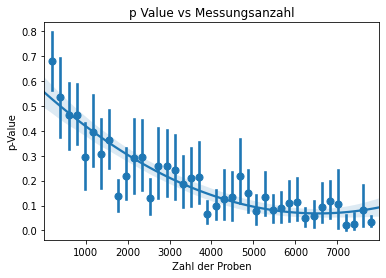

In [25]:
ax = sns.regplot(x='index',y='pval', data=dat, x_bins=40,order=2)
ax.set_title("p Value vs Messungsanzahl")
ax.set(xlabel='Zahl der Proben', ylabel='p-Value')

In [26]:
# Extend investigation into the lift axis

In [31]:
# Add also the dimension of lift to test

lifts = np.linspace(0,.27,num=200) # between 0 and 30% increase
users = [n*10 for n in range(1, 800)]  # 100 to 10000 users
repetitions = 4

count = 0

p_val_norm = pd.DataFrame()
p_val_binom = pd.DataFrame()

for user in tqdm(users):
    for lift in lifts:  
        for repetition in range(repetitions):
            count +=1

            
            pn, pb = simulate_ABtest(ug, user, lift)
            
#            p_val_norm_dict[f'{lift}-{user}-{repetition}'] = pn
#            p_val_binom_dict[f'{lift}-{user}-{repetition}'] = pb
            
            
            p_val_norm = p_val_norm.append(pd.Series({'lift':lift, 'users':user,'rep': repetition, 'pval':pn}),ignore_index=True )
            p_val_binom = p_val_norm.append(pd.Series({'lift':lift, 'users':user,'rep':repetition, 'pval':pb}),ignore_index=True )


 19%|█▉        | 150/799 [57:35<6:37:53, 36.79s/it]


 37%|███▋      | 293/799 [2:56:44<8:51:40, 63.04s/it]


 55%|█████▍    | 436/799 [5:57:51<8:53:53, 88.25s/it]


 72%|███████▏  | 575/799 [9:54:30<7:07:52, 114.61s/it]

KeyboardInterrupt: 

In [32]:
p_val_binom.to_csv('pvalues_binom_table_more_detailled.csv')
p_val_norm.to_csv('pvalues_norm_table_more_detailled.csv')

In [157]:
#p_val_binom.to_csv('pvalues_binom_table.csv')
#p_val_norm.to_csv('pvalues_norm_table.csv')

In [4]:
p_val_binom = pd.read_csv('../pvalues_binom_table.csv', index_col=0)
p_val_norm = pd.read_csv('../pvalues_norm_table.csv', index_col=0)

In [37]:
p_val_binom.dropna(inplace=True)
p_val_norm.dropna(inplace=True)

In [38]:
from mpl_toolkits.mplot3d import Axes3D

In [39]:
p_val_binom.head(1)

,lift,pval,rep,users
0,0.0,0.346594,0.0,10.0


In [8]:
p_val_binom = p_val_binom.loc[p_val_binom.users < 8000]
p_val_binom = p_val_binom.loc[p_val_binom.lift < 0.2]

p_val_norm = p_val_norm.loc[p_val_norm.users < 8000]
p_val_norm = p_val_norm.loc[p_val_norm.lift < 0.2]

In [40]:
def plot_pval(value):
    if value < 0.05:
        return value * 10
    return value 

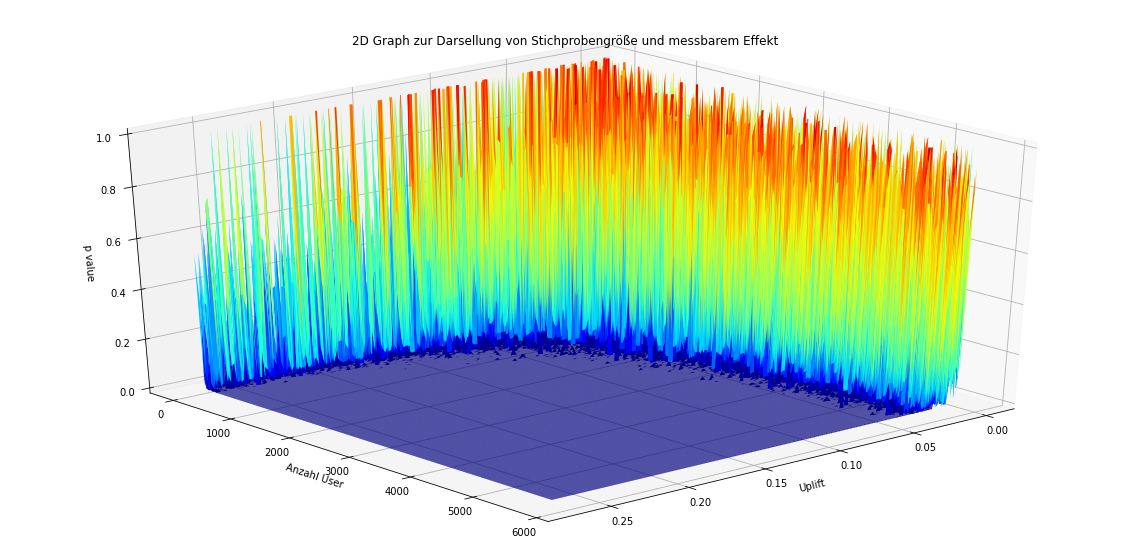

In [43]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
# Other palette
ax.plot_trisurf(p_val_binom['lift'],p_val_binom['users'], p_val_binom['pval'], cmap=plt.cm.jet, linewidth=0.01)

ax.set_title("2D Graph zur Darsellung von Stichprobengröße und messbarem Effekt") 
ax.set(xlabel='Uplift', ylabel='Anzahl User',zlabel='p value')
# Rotate it
ax.view_init(30, 49)

#ax.set_zscale(plot_pval)

plt.show()

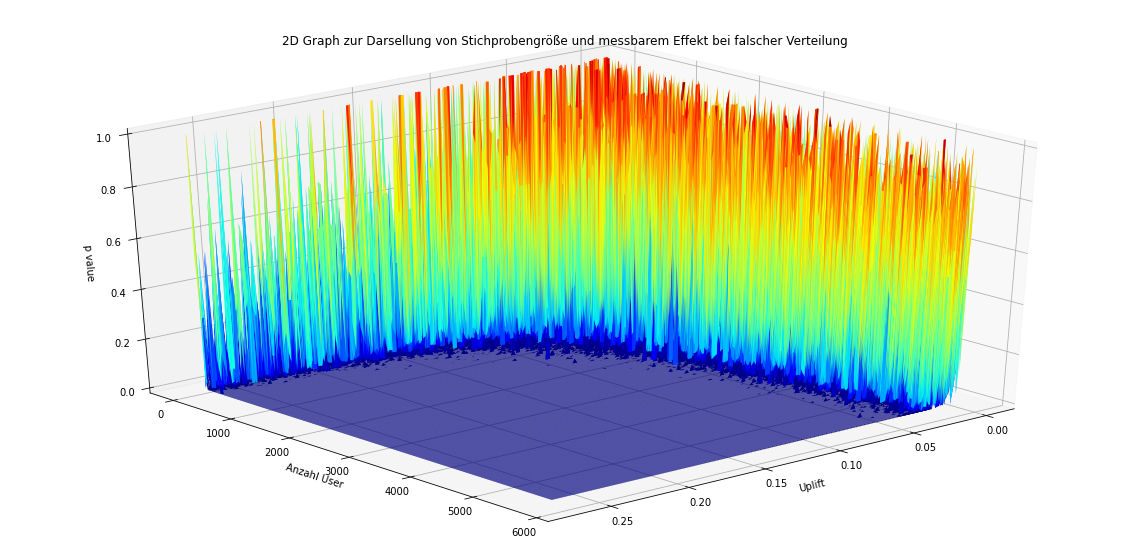

In [44]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
# Other palette
ax.plot_trisurf(p_val_norm['lift'],p_val_norm['users'], p_val_norm['pval'], cmap=plt.cm.jet, linewidth=0.01)

ax.set_title("2D Graph zur Darsellung von Stichprobengröße und messbarem Effekt bei falscher Verteilung") 
ax.set(xlabel='Uplift', ylabel='Anzahl User',zlabel='p value')
# Rotate it
ax.view_init(30, 49)

plt.show()

In [62]:
# set a significance level for plotting
p_val_binom['signifikanz'] = 0.05

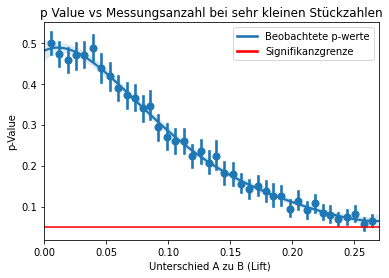

In [96]:
ax = sns.regplot(x='lift',y='pval', data=p_val_binom.loc[p_val_binom.users < 200], x_bins=40,order=5)
ax = sns.lineplot(x='lift', y='signifikanz',data=p_val_binom.loc[p_val_binom.users < 200], color='red',legend='brief')

ax.set_title("p Value vs Messungsanzahl bei sehr kleinen Stückzahlen")
ax.set(xlabel='Unterschied A zu B (Lift) ', ylabel='p-Value')
legend = ax.legend(labels=["Beobachtete p-werte","Signifikanzgrenze"])
legend.legendHandles[1].set_color('red')


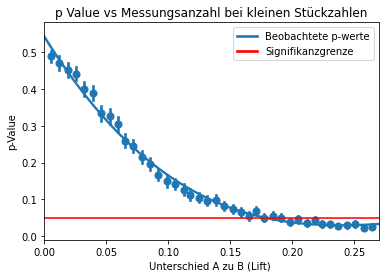

In [92]:
ax = sns.regplot(x='lift',y='pval', data=p_val_binom.loc[p_val_binom.users < 500], x_bins=40,order=3)
ax = sns.lineplot(x='lift', y='signifikanz',data=p_val_binom.loc[p_val_binom.users < 200], color='red',legend='brief')

ax.set_title("p Value vs Messungsanzahl bei kleinen Stückzahlen")
ax.set(xlabel='Unterschied A zu B (Lift) ', ylabel='p-Value')
legend = ax.legend(labels=["Beobachtete p-werte","Signifikanzgrenze"])
legend.legendHandles[1].set_color('red')


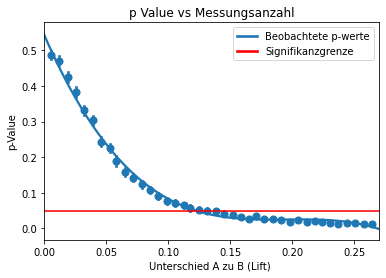

In [93]:
ax = sns.regplot(x='lift',y='pval', data=p_val_binom.loc[p_val_binom.users < 1000], x_bins=40,order=3)
ax = sns.lineplot(x='lift', y='signifikanz',data=p_val_binom.loc[p_val_binom.users < 200], color='red',legend='brief')

ax.set_title("p Value vs Messungsanzahl")
ax.set(xlabel='Unterschied A zu B (Lift) ', ylabel='p-Value')
legend = ax.legend(labels=["Beobachtete p-werte","Signifikanzgrenze"])
legend.legendHandles[1].set_color('red')


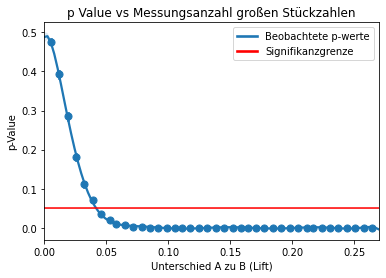

In [94]:
ax = sns.regplot(x='lift',y='pval', data=p_val_binom.loc[(p_val_binom.users > 1000) & (p_val_binom.users < 3000) ], x_bins=40,order=10)
ax = sns.lineplot(x='lift', y='signifikanz',data=p_val_binom.loc[p_val_binom.users < 200], color='red',legend='brief')

ax.set_title("p Value vs Messungsanzahl großen Stückzahlen")
ax.set(xlabel='Unterschied A zu B (Lift)', ylabel='p-Value')
legend = ax.legend(labels=["Beobachtete p-werte","Signifikanzgrenze"])
legend.legendHandles[1].set_color('red')


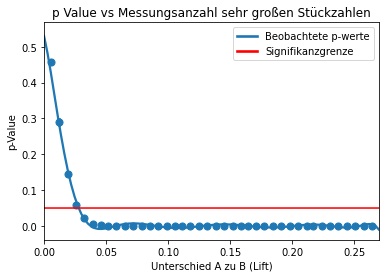

In [95]:
ax = sns.regplot(x='lift',y='pval', data=p_val_binom.loc[(p_val_binom.users > 3000) ], x_bins=40,order=10)
ax = sns.lineplot(x='lift', y='signifikanz',data=p_val_binom.loc[p_val_binom.users < 200], color='red',legend='brief')

ax.set_title("p Value vs Messungsanzahl sehr großen Stückzahlen")
ax.set(xlabel='Unterschied A zu B (Lift)', ylabel='p-Value')
legend = ax.legend(labels=["Beobachtete p-werte","Signifikanzgrenze"])
legend.legendHandles[1].set_color('red')


In [179]:
users = p_val_binom.groupby('users').size().index.tolist()
measurable_difference = {}

for user in users:
    # only get those users
    dat = p_val_binom.loc[p_val_binom.users==user]
    
    # average pvalue for all replicas
    lift = pd.DataFrame(dat.groupby('lift')['pval'].mean() )
    measurable_difference[user] = {"min_difference":lift.loc[lift.pval < 0.05].index.to_series().min() }


In [180]:
measurable_difference = pd.DataFrame.from_dict(  measurable_difference, orient='index').fillna(0.15)
measurable_difference['user_nr'] = measurable_difference.index.to_series()

In [186]:
#measurable_difference_subset = measurable_difference.loc[measurable_difference.user_nr < 4000]

In [1]:
measurable_difference_subset

NameError: name 'measurable_difference_subset' is not defined

In [ ]:
ax = sns.regplot(x='user_nr',y='min_difference' ,logistic=True,data=measurable_difference_subset, scatter=False )
ax.set_title("Messbarer Unterschied zu Userzahl")
ax.set(xlabel='Zahl der User', ylabel='Unterschied A zu B ')

In [155]:
z = np.polyfit(x=measurable_difference['index'], y=measurable_difference['min_difference'], deg = 4)